# 一、 模型评估
## 1.混淆矩阵

* tf.argmax(input,axis)根据axis取值的不同返回每行或者每列最大值的索引。
* 混淆矩阵是机器学习中总结分类模型预测结果的情形分析表，以矩阵形式将数据集中的记录按照真实的类别与分类模型作出的分类判断两个标准进行汇总.<br>
  sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)<br>
  y_true: 是样本真实分类结果，y_pred: 是样本预测分类结果;<br>
  labels：是所给出的类别，通过这个可对类别进行选择;<br>
  sample_weight : 样本权重;<br>
* tf.cast()函数的作用是执行 tensorflow 中张量数据类型转换，比如读入的图片如果是int8类型的，一般在要在训练前把图像的数据格式转换为float32.<br>
  cast(x, dtype, name=None); <br>
    第一个参数 x:   待转换的数据（张量）<br>
    第二个参数 dtype： 目标数据类型<br>
    第三个参数 name： 可选参数，定义操作的名称<br>

## 2.性能评估

### （1）基本概念
  TP、True Positive  真阳性：预测为正，实际也为正；<br>
  FP、False Positive  假阳性：预测为正，实际为负；<br>
  FN、False Negative 假阴性：预测与负、实际为正；<br>
  TN、True Negative 真阴性：预测为负、实际也为负。<br>
  
### （2）精确度、查全率、F1
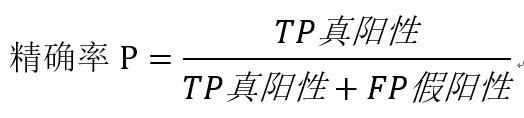
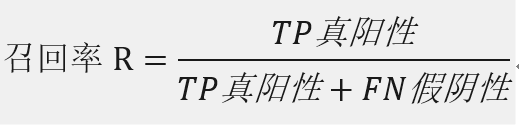
*F1分数（F1-Score），又称为平衡F分数（BalancedScore），它被定义为精确率和召回率的调和平均数；
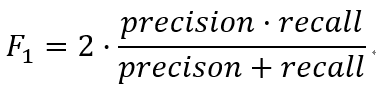

In [ ]:
#矩阵存储；混淆矩阵
  def add_metrics_op(self):
    with tf.compat.v1.variable_scope("metrics"):

      Y= tf.argmax(input=self.Y, axis=-1)
      confusion_matrix = tf.cast(tf.math.confusion_matrix(
          labels=tf.reshape(Y, [-1]), 
          predictions=tf.reshape(self.preds, [-1]), 
          num_classes=self.n_class, name='confusion_matrix'),
          dtype=tf.float32)
#性能评估：预测P、S到时的precision\recall\f1
      # with tf.variable_scope("P"):
      c = tf.constant(1e-7, dtype=tf.float32)  #加上一个极小变量，防止分母为0；
      precision_P =  (confusion_matrix[1,1] + c) / (tf.reduce_sum(input_tensor=confusion_matrix[:,1]) + c)
      recall_P = (confusion_matrix[1,1] + c) / (tf.reduce_sum(input_tensor=confusion_matrix[1,:]) + c)
      f1_P = 2 * precision_P * recall_P / (precision_P + recall_P)

      tmp1 = tf.compat.v1.summary.scalar("train_precision_p", precision_P)
      tmp2 = tf.compat.v1.summary.scalar("train_recall_p", recall_P)
      tmp3 = tf.compat.v1.summary.scalar("train_f1_p", f1_P)
      self.summary_train.extend([tmp1, tmp2, tmp3])    #P波训练集的精度评估

      tmp1 = tf.compat.v1.summary.scalar("valid_precision_p", precision_P)
      tmp2 = tf.compat.v1.summary.scalar("valid_recall_p", recall_P)
      tmp3 = tf.compat.v1.summary.scalar("valid_f1_p", f1_P)
      self.summary_valid.extend([tmp1, tmp2, tmp3])    #P波验证集的精度评估

      # with tf.variable_scope("S"):
      precision_S =  (confusion_matrix[2,2] + c) / (tf.reduce_sum(input_tensor=confusion_matrix[:,2]) + c)
      recall_S = (confusion_matrix[2,2] + c) / (tf.reduce_sum(input_tensor=confusion_matrix[2,:]) + c)
      f1_S = 2 * precision_S * recall_S / (precision_S + recall_S)

      tmp1 = tf.compat.v1.summary.scalar("train_precision_s", precision_S)
      tmp2 = tf.compat.v1.summary.scalar("train_recall_s", recall_S)
      tmp3 = tf.compat.v1.summary.scalar("train_f1_s", f1_S)
      self.summary_train.extend([tmp1, tmp2, tmp3])    #S波训练集的精度评估

      tmp1 = tf.compat.v1.summary.scalar("valid_precision_s", precision_S)
      tmp2 = tf.compat.v1.summary.scalar("valid_recall_s", recall_S)
      tmp3 = tf.compat.v1.summary.scalar("valid_f1_s", f1_S)
      self.summary_valid.extend([tmp1, tmp2, tmp3])    #S波验证集的精度评估
      
      self.precision = [precision_P, precision_S]
      self.recall = [recall_P, recall_S]
      self.f1 = [f1_P, f1_S]                    #P、S总结

#  二、模型参数

## 1.函数解析
* sess.run（）函数：sess.run(fetches，feed_dict)：fetches 可以是list或者tensor向量；feed_dict：替换原图中的某个tensor。<br>
  例子：a=tf.add(2,5)     #这里本来a为7<br>
  b=tf.multiply(a,3)  #b=21<br>
  sess=tf.Session()<br>
  replace_dict={a:15}  #把a=15替换原a<br>
  sess.run(b,feed_dict=replace_dict) #这里就是用新a替换掉旧a。所以结果为15X3=45<br>
  链接：https://www.jianshu.com/p/4a8277f9cac0<br>
    
* tf.summary.FileWriter:指定一个文件用来保存图.<br>
  tf.summary.FileWritter(path,sess.graph):可以调用其add_summary（）方法将训练过程数据保存在filewriter指定的文件中<br>
    
* tf.summary.merge：tf.summary.merge(inputs, collections=None, name=None)
  一般选择要保存的信息还需要用到tf.get_collection()函数；使用tf.get_collection函数筛选图中summary信息中的accuracy信息，这里的
  tf.GraphKeys.SUMMARIES 是summary在collection中的标志。<br>
  举例：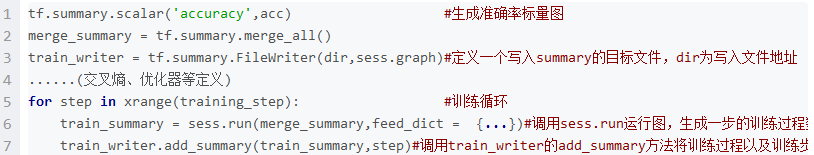**</font>

In [ ]:
#模型训练参数
  def train_on_batch(self, sess, inputs_batch, labels_batch, summary_writer, drop_rate=0.0):
    feed = {self.X: inputs_batch,
            self.Y: labels_batch,
            self.drop_rate: drop_rate,
            self.is_training: True}
            

    _, step_summary, step, loss = sess.run([self.train_op,
                                            self.summary_train,
                                            self.global_step,
                                            self.loss],
                                            feed_dict=feed)
    summary_writer.add_summary(step_summary, step)
    return loss

#模型验证参数
  def valid_on_batch(self, sess, inputs_batch, labels_batch, summary_writer):
    feed = {self.X: inputs_batch,
            self.Y: labels_batch,
            self.drop_rate: 0,
            self.is_training: False}
            
    step_summary, step, loss, preds = sess.run([self.summary_valid,
                                                self.global_step,
                                                self.loss,
                                                self.preds],
                                                feed_dict=feed)
    summary_writer.add_summary(step_summary, step)
    return loss, preds

  # def train_on_batch(self, sess, summary_writer, drop_rate=0.0, raw_data=False):
  #   feed = {self.drop_rate: drop_rate,
  #           self.is_training: True}
  #   if raw_data:
  #     _, step_summary, step, loss, preds, logits, \
  #     X_batch, Y_batch = sess.run([self.train_op, 
  #                                  self.summary_train,
  #                                  self.global_step,
  #                                  self.loss,
  #                                  self.preds,
  #                                  self.logits,
  #                                  self.X,
  #                                  self.Y],
  #                                  feed_dict=feed)
  #     summary_writer.add_summary(step_summary, step)
  #     return loss, preds, logits, X_batch, Y_batch
  #   else:
  #     _, step_summary, step, loss = sess.run([self.train_op,
  #                         self.summary_train,
  #                         self.global_step,
  #                         self.loss],
  #                         feed_dict=feed)
  #     summary_writer.add_summary(step_summary, step)
  #     return loss
#模型测试参数
  def test_on_batch(self, sess, summary_writer):
    feed = {self.drop_rate: 0,
            self.is_training: False}
    step_summary, step, loss, preds, \
    X_batch, Y_batch, fname_batch, \
    itp_batch, its_batch = sess.run([self.summary_valid,
                                     self.global_step,
                                     self.loss,
                                     self.preds,
                                     self.X,
                                     self.Y,
                                     self.input_batch[2],
                                     self.input_batch[3],
                                     self.input_batch[4]],
                                     feed_dict=feed)
    summary_writer.add_summary(step_summary, step)
    return loss, preds, X_batch, Y_batch, fname_batch, itp_batch, its_batch


  def build(self, input_batch=None, mode='train'):
    self.add_placeholders(input_batch, mode)
    self.add_prediction_op()
    if mode in ["train", "valid", "test"]:
      self.add_loss_op()
      self.add_training_op()
      # self.add_metrics_op()
      self.summary_train = tf.compat.v1.summary.merge(self.summary_train)
      self.summary_valid = tf.compat.v1.summary.merge(self.summary_valid)
    return 0
